#### Data generator

In [1]:

from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis as sci_kurtosis

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
"""
Generate synthetic student dataset (non-Gaussian shapes).

Preconditions:
- Python 3.8+
- numpy, pandas installed
- n is positive integer

Invariants:
- len(df) == n
- 0 <= math_score <= 100
- 0 <= science_score <= 100
- study_hours > 0 (<= 24)
- 0 <= attendance_rate <= 1
- gender in {"M","F"} as categorical

Postconditions:
- Returns pandas.DataFrame with columns:
  ['student_id','math_score','science_score','study_hours','gender','attendance_rate']

Complexity:
- Time: O(n)
- Space: O(n) (arrays + DataFrame)
"""


def generate_student_dataset_non_gaussian(
    n: int = 30000,
    seed: Optional[int] = 42,
) -> pd.DataFrame:
    """
    Generate synthetic dataset where not all variables follow a bell curve.

    Args:
        n: number of rows (default 30000)
        seed: int or None for RNG seed

    Returns:
        pandas.DataFrame
    """
    if not (isinstance(n, int) and n > 0):
        raise ValueError("n must be a positive integer")

    rng = np.random.default_rng(seed)

    # 1) student_id (compact)
    student_id = np.arange(1, n + 1, dtype=np.int32)

    # 2) math_score: scaled Beta -> right-skewed distribution in [0,100]
    # Beta(a,b) with a=5,b=2 produces a distribution with majority of mass toward 1 (high scores)
    a_math, b_math = 5.0, 2.0
    math_unscaled = rng.beta(a_math, b_math, size=n)  # in (0,1)
    math_score = (math_unscaled * 100.0).astype(np.float32)  # scale to 0-100

    # 3) science_score: bimodal mixture of two normals (non-Gaussian overall)
    # Component A: N(60, 8), Component B: N(78, 6)
    p_comp_b = 0.45  # proportion of component B
    choice_mask = rng.random(size=n) < p_comp_b
    # generate both arrays at once (vectorized)
    sci_a = rng.normal(loc=60.0, scale=8.0, size=n)
    sci_b = rng.normal(loc=78.0, scale=6.0, size=n)
    science_score = np.where(choice_mask, sci_b, sci_a).astype(np.float32)
    # Clip to valid score range
    science_score = np.clip(science_score, 0.0, 100.0)

    # 4) study_hours: LogNormal (right-skewed)
    s_sigma = 0.6
    target_mean = 3.5
    s_mu = np.log(target_mean) - (s_sigma ** 2) / 2.0
    study_hours = rng.lognormal(mean=s_mu, sigma=s_sigma, size=n).astype(np.float32)
    study_hours = np.clip(study_hours, 0.01, 24.0)

    # 5) attendance_rate: Beta concentrated near high attendance
    att_alpha, att_beta = 17.0, 3.0
    attendance_rate = rng.beta(att_alpha, att_beta, size=n).astype(np.float32)
    attendance_rate = np.clip(attendance_rate, 0.0, 1.0)

    # 6) gender: Bernoulli -> categorical
    gender_bool = rng.random(size=n) < 0.5
    gender = np.where(gender_bool, "M", "F")

    # assemble DataFrame efficiently
    df = pd.DataFrame(
        {
            "student_id": student_id,
            "math_score": math_score,
            "science_score": science_score,
            "study_hours": study_hours,
            "gender": gender,
            "attendance_rate": attendance_rate,
        }
    )

    # memory optimization
    df["gender"] = df["gender"].astype("category")

    # Postcondition checks
    assert len(df) == n, "row count mismatch"
    assert df["math_score"].between(0.0, 100.0).all(), "math_score out of range"
    assert df["science_score"].between(0.0, 100.0).all(), "science_score out of range"
    assert (df["study_hours"] > 0).all(), "study_hours must be positive"
    assert df["attendance_rate"].between(0.0, 1.0).all(), "attendance_rate out of range"
    assert set(df["gender"].cat.categories).issubset({"M", "F"}), "invalid gender categories"

    return df


# Example:
# df = generate_student_dataset_non_ga


In [4]:
df = generate_student_dataset_non_gaussian(n=30000, seed=42)
df.info(memory_usage="deep")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   student_id       30000 non-null  int32   
 1   math_score       30000 non-null  float32 
 2   science_score    30000 non-null  float32 
 3   study_hours      30000 non-null  float32 
 4   gender           30000 non-null  category
 5   attendance_rate  30000 non-null  float32 
dtypes: category(1), float32(4), int32(1)
memory usage: 615.6 KB


,student_id,math_score,science_score,study_hours,gender,attendance_rate
0,1,65.387634,74.147026,4.765113,F,0.811084
1,2,75.049690,86.103516,2.996502,F,0.886920
2,3,79.586296,56.840267,3.146319,M,0.938505
3,4,72.427025,65.030731,2.966723,F,0.797514
4,5,82.602150,68.292458,2.512452,F,0.737730


In [5]:
df.describe()

,student_id,math_score,science_score,study_hours,attendance_rate
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,71.411499,68.173393,3.507262,0.850380
std,8660.398374,16.018423,11.409937,2.290842,0.077897
min,1.000000,9.324898,31.890398,0.249319,0.334726
25%,7500.750000,60.882374,59.179704,1.962674,0.804030
50%,15000.500000,73.452087,68.706936,2.942900,0.861431
75%,22500.250000,83.898134,77.520781,4.391618,0.908893
max,30000.000000,99.946732,100.000000,24.000000,0.998716


### Problem solving from the dataset

Medium (5 Questions)

1. Compute mean, median, and mode of math_score, and explain what each tells you about the distribution.
Why: Solidifies central tendency interpretation.

2. Compute the skewness and kurtosis of science_score. Interpret if it is symmetric, heavy-tailed, or light-tailed.
Why: Applies shape analysis.

3. Find the coefficient of variation for study_hours.
Why: Teaches normalized dispersion.

4. Compute the probability that a randomly chosen student has attendance_rate > 0.80.
Why: Simple probability based on frequency definition.

5. Compute P(Male ∩ High Math Score) where high math score = score > 75.
Why: Applies basic probability + set intersection.

##### Compute mean, median, and mode of math_score, and explain what each tells you about the distribution.

In [6]:
# Compute mean, median, and mode of math_score, and explain what each tells you about the distribution.

math_mean = df["math_score"].sum() / df["math_score"].count()
math_mean

np.float64(71.4115)

The average score in math across all students is 70.07

##### Compute the skewness and kurtosis of science_score. Interpret if it is symmetric, heavy-tailed, or light-tailed.

In [7]:
# Compute the skewness and kurtosis of science_score. Interpret if it is symmetric, heavy-tailed, or light-tailed.
science_mean = np.mean(df["science_score"])
science_median = np.median(df["science_score"])

science_sk = science_mean - science_median
science_sk

np.float32(-0.53354645)

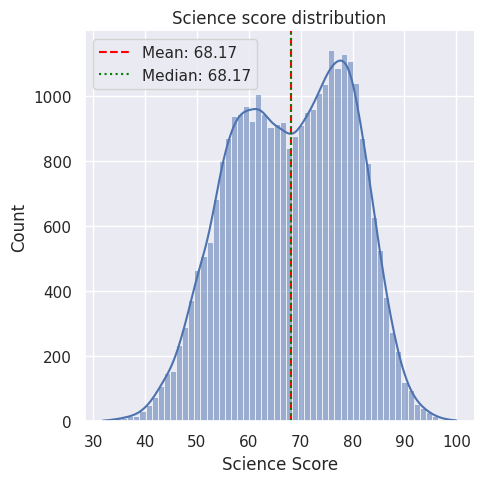

In [8]:
ax = sns.displot(
    df,
    x="science_score",
    facet_kws=dict(margin_titles=True),
    kde=True
)
plt.axvline(science_mean, color="red", linestyle="--", label=f'Mean: {science_mean:.2f}')
plt.axvline(science_mean, color="green", linestyle=":", label=f'Median: {science_mean:.2f}')
plt.title("Science score distribution")
plt.legend()
plt.xlabel("Science Score")
plt.tight_layout()
plt.show()

Science score across the students has a right skewness with a light-tail and few outliers. The `absolute measure of skewness` is `0.019`

##### Find the coefficient of variation for study_hours.

In [9]:
def standard_dev_mean(col):
    mean = np.mean(col)
    sd = np.sqrt(sum((col - mean) ** 2) / len(col))
    return (sd, mean)

In [10]:
# Find the coefficient of variation for study_hours.

# coeff of dispersion
sd, mean = standard_dev_mean(df['study_hours'])
coeff_of_dispersion = sd / mean
coeff_of_variation = coeff_of_dispersion * 100

print(f"Standard deviation: {sd}, Mean: {mean}")
print(f"Coeff of dispersion: {coeff_of_dispersion}")
print(f"Coeff of variation: {coeff_of_variation}%")

Standard deviation: 2.2908037040363967, Mean: 3.5072624683380127
Coeff of dispersion: 0.6531600428301964
Coeff of variation: 65.31600428301964%


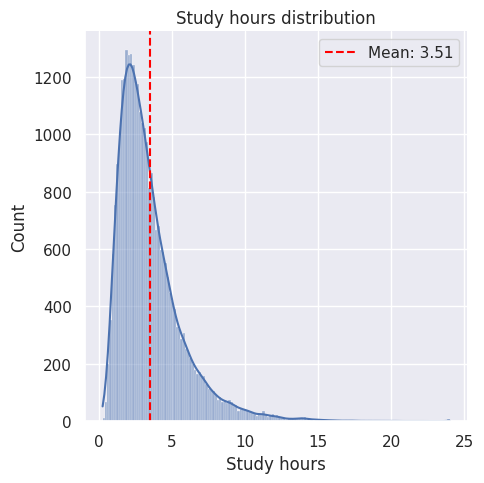

In [11]:
ax = sns.displot(
    df,
    x="study_hours",
    facet_kws=dict(margin_titles=True),
    kde=True
)
plt.axvline(mean, color='red', linestyle="--", label=f"Mean: {mean:.2f}")
plt.title("Study hours distribution")
plt.xlabel("Study hours")
plt.legend()
plt.tight_layout()
plt.show()

##### Compute the probability that a randomly chosen student has attendance_rate > 0.80

In [12]:
no_of_students_above_80_per = df[df["attendance_rate"] > 0.80].count()
probablity_of_random_above_80 = no_of_students_above_80_per / len(df)
print(f"Probablity of a random student has attendance rate above 0.80: {probablity_of_random_above_80['attendance_rate']}")

Probablity of a random student has attendance rate above 0.80: 0.7627666666666667


##### Compute P(Male ∩ High Math Score) where high math score = score > 75.

In [13]:
male_with_high_math_score_count = df.query('math_score > 75 and gender == "M"').count()
probablity_male_high_score = male_with_high_math_score_count['math_score'] / len(df)
print(f"Probablity of male who score 75 in Math: {probablity_male_high_score}")

Probablity of male who score 75 in Math: 0.2344


Hard (25 Questions)

##### Compare central tendency (mean, median) for math_score. Determine statistically whether the distribution is left- or right-skewed.

In [14]:
sd_math, mean_math = standard_dev_mean(df['math_score'])
median_math = np.median(df['math_score'])

sk_math = (3 * (mean_math - median_math)) / sd_math
print(f"Skewness: {sk_math}")

Skewness: -0.3821766349783516


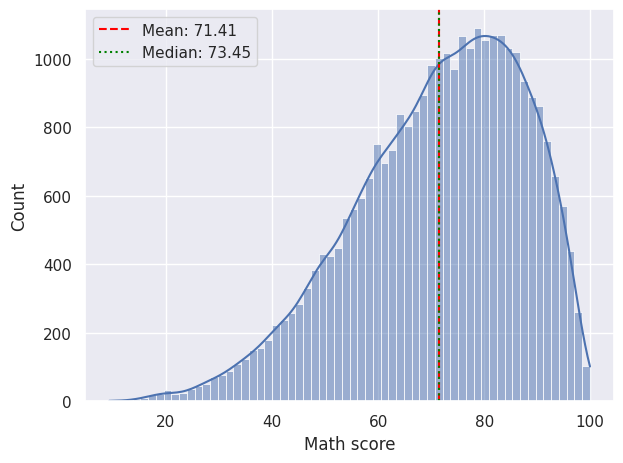

In [15]:
sns.histplot(
    df,
    x='math_score',
    kde=True
)
plt.axvline(mean_math, color="red", linestyle="--", label=f"Mean: {mean_math:.2f}")
plt.axvline(mean_math, color="green", linestyle=":", label=f"Median: {median_math:.2f}")
plt.xlabel("Math score")
plt.legend()
plt.tight_layout()
plt.show()

##### Detect and justify outliers in science_score using:

- Z-score method
- IQR method

What is Z-Score?

Z-score, also known as the standard score, tells us the deviation of a data point from the mean by expressing it in terms of standard deviations above or below the mean. It gives us an idea of how far a data point is from the mean. Hence, the Z-Score is measured in terms of standard deviation from the mean. For example, a Z-score of 2 indicates the value is 2 standard deviations away from the mean. To use a z-score, we need to know the population mean (μ) and also the population standard deviation (σ).

Z-score is a statistical measure that describes a value's position relative to the mean of a group of values. It is expressed in terms of standard deviations from the mean. The Z-score indicates how many standard deviations an element is from the mean.

Z-Score Formula
To calculate the z- score for any given data we need the value of the element along with the mean and standard deviation. A z-score can be calculated using the following Z- score formula. 

`z = (X - μ) / σ`

where,
- z = Z-Score
- X = Value of Element
- μ = Population Mean
- σ = Population Standard Deviation 

How to interpret Z- score

- Z-Score = 0: A Z-score of 0 indicates that the data point is exactly at the mean of the distribution.
- Positive Z-Score: A positive Z-score indicates that the data point is above the mean. For example, a Z-score of 1.5 means the data point is 1.5 standard deviations above the mean.
- Negative Z-Score: A negative Z-score indicates that the data point is below the mean. For example, a Z-score of -2 means the data point is 2 standard deviations below the mean.
- Magnitude of Z-Score: The magnitude of the Z-score shows how far away the data point is from the mean. A larger absolute value of the Z-score indicates that the data point is farther from the mean, while a smaller absolute value indicates it is closer.

Common Thresholds:
- Z-Score > 2 or < -2: Often considered unusual or significant, indicating the data point is more than 2 standard deviations away from the mean.
- Z-Score > 3 or < -3: Typically considered an outlier, suggesting the data point is extremely far from the mean.


In [16]:
science_df = df.copy()
science_df

,student_id,math_score,science_score,study_hours,gender,attendance_rate
0,1,65.387634,74.147026,4.765113,F,0.811084
1,2,75.049690,86.103516,2.996502,F,0.886920
2,3,79.586296,56.840267,3.146319,M,0.938505
3,4,72.427025,65.030731,2.966723,F,0.797514
4,5,82.602150,68.292458,2.512452,F,0.737730
...,...,...,...,...,...,...
29995,29996,61.262596,56.534119,6.223295,F,0.915200
29996,29997,66.401321,84.924316,5.245293,F,0.846940
29997,29998,68.504120,84.525475,1.371579,F,0.890075
29998,29999,23.355793,79.292465,2.631215,F,0.924776


In [17]:
sd, mean = standard_dev_mean(science_df['science_score'])
print(sd, mean)

11.409746536447448 68.17339


In [18]:
science_df['zscore_science'] = (science_df['science_score'] - mean) / sd
science_df.head()

,student_id,math_score,science_score,study_hours,gender,attendance_rate,zscore_science
0,1,65.387634,74.147026,4.765113,F,0.811084,0.523555
1,2,75.049690,86.103516,2.996502,F,0.886920,1.571474
2,3,79.586296,56.840267,3.146319,M,0.938505,-0.993285
3,4,72.427025,65.030731,2.966723,F,0.797514,-0.275437
4,5,82.602150,68.292458,2.512452,F,0.737730,0.010435


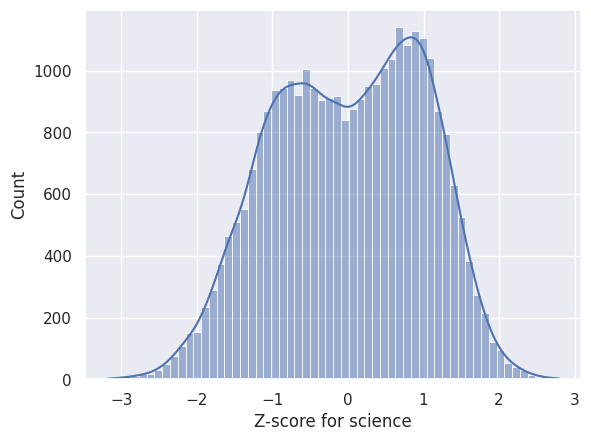

In [19]:
# Plot the Z-score of science score

sns.histplot(
    science_df,
    x="zscore_science",
    kde=True
)
plt.xlabel("Z-score for science")
plt.show()

In [20]:
science_data_outlier = science_df.query('zscore_science > 3 or zscore_science < -3')['science_score'].count()
print(f"Total outlier data in science score: {science_data_outlier}, which is {science_data_outlier / len(science_df) * 100}% of data.")

Total outlier data in science score: 5, which is 0.016666666666666666% of data.


We have few data points that are outside the +3 & -3 range, which are considered as outliers. We have very few data points that are outside these ranges, so we have very few outliers.
Also, to consider that science score has very few data points that are outside +2 & -2 so that is also an outlier in the dataset.

Now doing the outlier analysis using IQR method

Detecting Outlier with IQR

IQR is used to measure variability by dividing a data set into quartiles. The data is sorted in ascending order and then we split it into 4 equal parts. The values Q1 (25th percentile), Q2 (50th percentile or median) and Q3 (75th percentile) separate dataset in 4 equal parts.

If a dataset has 2n or 2n+1 data points, then

Q2 = median of the dataset.
Q1 = median of n smallest data points.
Q3 = median of n highest data points.
The IQR is calculated as: `IQR=Q3−Q1 = Q3 - Q1`

Data points that fall below `Q1−1.5×IQR` or above `Q3+1.5×IQR` are considered outliers.

In [21]:
q1_science_score = np.percentile(science_df['science_score'], 25, interpolation='midpoint')
q2_science_score = np.percentile(science_df['science_score'], 50, interpolation='midpoint')
q3_science_score = np.percentile(science_df['science_score'], 75, interpolation='midpoint')

print(q1_science_score, q2_science_score, q3_science_score)

59.17945 68.70694 77.520996


In [22]:
iqr = q3_science_score - q1_science_score
print(iqr)

18.341545


In [23]:
science_score_lower_limit = q1_science_score - (1.5 * iqr)
science_score_upper_limit = q3_science_score + (1.5 * iqr)

print(science_score_lower_limit, science_score_upper_limit)

31.667133 105.03331


In [24]:
science_data_outlier = science_df.query(f'science_score > {science_score_upper_limit} or science_score < {science_score_lower_limit}')['science_score'].count()
print(f"Total outlier data in science score: {science_data_outlier}, which is {science_data_outlier / len(science_df) * 100}% of data.")

Total outlier data in science score: 0, which is 0.0% of data.


Z-score showed 5 data points as outliers, while IQR showed 0. Z-core is more sensitive in detecting outliers.

##### Calculate Pearson’s coefficient of skewness for math_score

In [25]:
math_sd, math_mean = standard_dev_mean(df['math_score'])
math_median = np.median(df['math_score'])

sk_pearson = 3 * (math_mean - math_median) / math_sd
print(sk_pearson)

-0.3821766349783516


Math score is negatively skewed - meaning the distribution is more towards the right and there is a tail towards the left but the tail is light-tailed

##### Compute kurtosis and determine whether the score distribution is platykurtic, mesokurtic, or leptokurtic.

What is Kurtosis and its Types?

While skewness focuses on the spread (tails) of normal distribution, kurtosis focuses more on the height. It tells us how peaked or flat our normal (or normal-like) distribution is. The term, which means curved or arched from Greek, was first coined by, unsurprisingly, from the British mathematician Karl Pearson (he spent his life studying probability distributions).

High kurtosis indicates:

- Sharp peakedness in the distribution’s center.
- More values concentrated around the mean than normal distribution.
- Heavier tails because of a higher concentration of extreme values or outliers in tails.
- Greater likelihood of extreme events.
- On the other hand, low kurtosis indicates:

Flat peak.
- Fewer values concentrated around the mean but still more than normal distribution.
- Lighter tails.
- Lower likelihood of extreme events.
- Depending on the degree, distributions have three types of kurtosis:

+ Mesokurtic distribution (kurtosis = 3, excess kurtosis = 0): perfect normal distribution or very close to it.
+ Leptokurtic distribution (kurtosis > 3, excess kurtosis > 0): sharp peak, heavy tails
+ Platykurtic distribution (kurtosis < 3, excess kurtosis < 0): flat peak, light tails

In [26]:
def kurtosis(data):
    n = len(data)
    sd, mean = standard_dev_mean(data)
    
    kurtosis = (1/n) * sum(((data - mean) / sd) ** 4) - 3

    return kurtosis 

In [27]:
def type_of_kurtosis(kurtosis_score):
    if kurtosis_score == 3:
        return "Mesokurtic"
    elif kurtosis_score > 3:
        return "Leptokurtic"
    elif kurtosis_score < 3:
        return "Platykurtic"
    else:
        return None

In [28]:
cols = ["math_score", "science_score", "study_hours", "attendance_rate"]
for column in cols:
    kurtosis_value_manual = kurtosis(df[column])
    kurtosis_value_sci = sci_kurtosis(df[column])

    print(f"Kurtosis (manual) for {column}: {kurtosis_value_manual}")
    print(f"Kurtosis (scipy) for {column}: {kurtosis_value_sci}")
    print(f"Type of kurtosis: {type_of_kurtosis(kurtosis_value_manual)}")
    print('--------------')

Kurtosis (manual) for math_score: -0.09157665799859904
Kurtosis (scipy) for math_score: -0.09157657623291016
Type of kurtosis: Platykurtic
--------------
Kurtosis (manual) for science_score: -0.77246474473433
Kurtosis (scipy) for science_score: -0.7724645137786865
Type of kurtosis: Platykurtic
--------------
Kurtosis (manual) for study_hours: 8.233686749712627
Kurtosis (scipy) for study_hours: 8.233685493469238
Type of kurtosis: Leptokurtic
--------------
Kurtosis (manual) for attendance_rate: 0.7359587984721006
Kurtosis (scipy) for attendance_rate: 0.7359597682952881
Type of kurtosis: Platykurtic
--------------


##### Create a grouped frequency table for math_score with class width = 10, then compute mean via midpoints.

Want higher statistical accuracy?

- equal-sized bins
- quantile bins
- custom variable-width bins
- weighted grouped mean

In [29]:
bins = np.arange(0, 110, 10)

df['math_bins'] = pd.cut(
    df['math_score'],
    bins=bins,
    right=False
)
df

,student_id,math_score,science_score,study_hours,gender,attendance_rate,math_bins
0,1,65.387634,74.147026,4.765113,F,0.811084,"[60, 70)"
1,2,75.049690,86.103516,2.996502,F,0.886920,"[70, 80)"
2,3,79.586296,56.840267,3.146319,M,0.938505,"[70, 80)"
3,4,72.427025,65.030731,2.966723,F,0.797514,"[70, 80)"
4,5,82.602150,68.292458,2.512452,F,0.737730,"[80, 90)"
...,...,...,...,...,...,...,...
29995,29996,61.262596,56.534119,6.223295,F,0.915200,"[60, 70)"
29996,29997,66.401321,84.924316,5.245293,F,0.846940,"[60, 70)"
29997,29998,68.504120,84.525475,1.371579,F,0.890075,"[60, 70)"
29998,29999,23.355793,79.292465,2.631215,F,0.924776,"[20, 30)"


In [30]:
freq = df['math_bins'].value_counts().sort_index().rename('frequency')
freq

math_bins
[0, 10)         2
[10, 20)       70
[20, 30)      276
[30, 40)      869
[40, 50)     2054
[50, 60)     3783
[60, 70)     5570
[70, 80)     7029
[80, 90)     6858
[90, 100)    3489
Name: frequency, dtype: int64

In [31]:
midpoints = [(interval.left + interval.right) / 2 for interval in freq.index]
midpoints

[np.float64(5.0),
 np.float64(15.0),
 np.float64(25.0),
 np.float64(35.0),
 np.float64(45.0),
 np.float64(55.0),
 np.float64(65.0),
 np.float64(75.0),
 np.float64(85.0),
 np.float64(95.0)]

In [32]:
grouped_table = pd.DataFrame({
    "interval": freq.index.astype(str),
    "midpoint": midpoints,
    "frequency": freq.values
})
grouped_table

,interval,midpoint,frequency
0,"[0, 10)",5.0,2
1,"[10, 20)",15.0,70
2,"[20, 30)",25.0,276
3,"[30, 40)",35.0,869
4,"[40, 50)",45.0,2054
5,"[50, 60)",55.0,3783
6,"[60, 70)",65.0,5570
7,"[70, 80)",75.0,7029
8,"[80, 90)",85.0,6858
9,"[90, 100)",95.0,3489


In [33]:
# Grouped mean formula: sum(f * m) / sum(f)

grouped_mean = (grouped_table['midpoint'] * grouped_table['frequency']).sum() / grouped_table['frequency'].sum()
grouped_mean

np.float64(71.416)

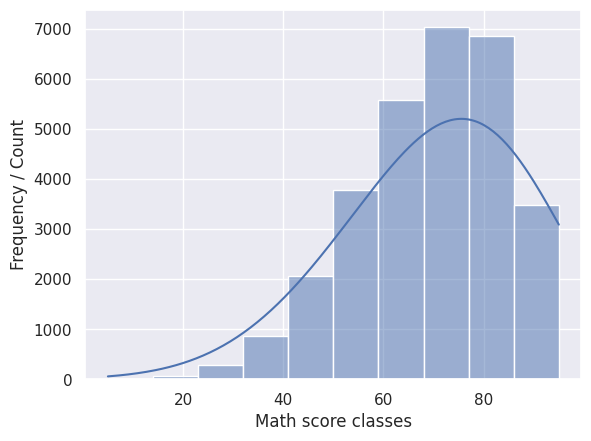

In [34]:
sns.histplot(
    grouped_table,
    x="midpoint",
    weights="frequency",
    bins=len(grouped_table),
    kde=True
)
plt.xlabel("Math score classes")
plt.ylabel("Frequency / Count")
plt.show()

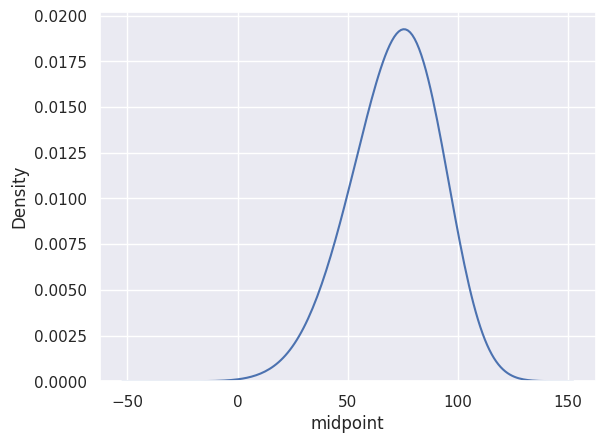

In [35]:
sns.kdeplot(
    grouped_table,
    x="midpoint",
    weights="frequency"
)
plt.show()

##### Compute the probability:

P({math_score} > 70 and {attendance_rate} > 0.9)

Conditional probability defines the probability of an event occurring based on a given condition or prior knowledge of another event.

It is the likelihood of an event occurring, given that another event has already occurred. In probability, this is denoted as A given B, expressed as P(A | B), indicating the probability of event A when the event B has already occurred.

The conditional probability formula is $P(A|B) = \frac{P(A \cap B)}{P(B)}$, where $P(A|B)$ is the probability of event A occurring given that event B has already occurred, $P(A \cap B)$ is the probability of both A and B occurring, and $P(B)$ is the probability of event B. The formula can also be rearranged as $P(B|A) = \frac{P(A \cap B)}{P(A)}$. 
Conditional Probability Formula 

• Formula: $P(A|B) = \frac{P(A \cap B)}{P(B)}$ 
• Where: 

	- $P(A|B)$: The conditional probability of event A occurring given that event B has occurred. 
	- $P(A \cap B)$: The probability of both events A and B occurring (the joint probability). 
	- $P(B)$: The probability of event B occurring. 

• Condition: This formula is valid only when the probability of event B is not zero, i.e., $P(B) \neq 0$. 

Alternative Formula 

• The formula can also be written to find the probability of event B given A: 
• Formula: $P(B|A) = \frac{P(A \cap B)}{P(A)}$ 

Explanation 

• The formula essentially calculates the likelihood of event A by focusing only on the outcomes where event B has already happened. 
• It's the ratio of the probability that both events occur to the probability that the given event (B) occurs. 

https://realpython.com/python-sets/



In [38]:
df_len = len(df)
p_math_score_gt_70 = df.query('math_score > 70').count().iloc[0] / df_len
p_attendance_gt_d9 = df.query('attendance_rate > 0.9').count().iloc[0] / df_len
p_math_score_and_attendance = df.query('math_score > 70 and attendance_rate > 0.9').count().iloc[0] / df_len

print(f"P(A) [Math score > 70] is {p_math_score_gt_70}")
print(f"P(B) [Attendance rate < 0.9] is {p_attendance_gt_d9}")
print(f"P(A intersect B) [Math score > 70 & Attendance rate < 0.9] is {p_math_score_and_attendance}")

P(A) [Math score > 70] is 0.5792
P(B) [Attendance rate < 0.9] is 0.2967666666666667
P(A intersect B) [Math score > 70 & Attendance rate < 0.9] is 0.16963333333333333


In [39]:
# The conditional probablity that when P(A|B)

cond_prob = p_math_score_and_attendance / p_attendance_gt_d9
print(f"Given attendance rate is > 0.9, math score > 70 has the probablity of {cond_prob}")

Given attendance rate is > 0.9, math score > 70 has the probablity of 0.5716050769403571


##### Compute:

𝑃(𝐴∪𝐵)

where:

A = “math_score > 75”

B = “study_hours > 4”

In [40]:
# inclusion-exclusion rule
df_len = len(df)
p_a = df.query("math_score > 75").count().iloc[0] / df_len
p_b = df.query("study_hours > 4").count().iloc[0] / df_len
p_a_int_b = df.query("math_score > 75 and study_hours > 4").count().iloc[0] / df_len

print(f'P(A): {p_a:.5f}')
print(f'P(B): {p_b:.5f}')
print(f'𝑃(A int B): {p_a_int_b:.5f}')

a_union_b = p_a + p_b - p_a_int_b

print(f'𝑃(𝐴∪𝐵): {a_union_b}')

P(A): 0.46537
P(B): 0.30243
𝑃(A int B): 0.14287
𝑃(𝐴∪𝐵): 0.6249333333333333


##### Are events A and B independent (using the above)? Prove using:

𝑃(𝐴∩𝐵)=𝑃(𝐴)𝑃(𝐵)

P(A∩B)=P(A)P(B)

In [43]:
print(round(p_a_int_b, 2) == round((p_a * p_b), 2))

True
